# Lab 3 — dimensionality reduction

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [3]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2

{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [4]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 2

{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


In [5]:
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
tag2name = dict(tags.map(itemgetter("tagId", "tag")).collect())

In [6]:
moviesGetter = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movies = dict(moviesGetter.map(itemgetter("movieId", "title")).collect())

In [7]:
scoresGetter = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

In [8]:
ratingsGetter = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

### Getting familiar with dataset

In [2]:
numberOfMovies = len(movies)
print('There are :', numberOfMovies, 'movies')

NameError: name 'movies' is not defined

In [3]:
numberOfTags = tags.map(itemgetter('tagId')).count()
print('There are :', numberOfTags, 'different tags')

NameError: name 'tags' is not defined

In [12]:
numberOfScores = scoresGetter.map(itemgetter("relevance")).count()
print("There are : ", numberOfScores, "scores.")

There are :  11709768 scores.


In [13]:
ratings = ratingsGetter.map(itemgetter("rating")).count()
print("There are : ", ratings, "ratings")

There are :  20000263 ratings


In [14]:
numberOfMoviesWithTags = scoresGetter.map(itemgetter('movieId')).distinct().count()
print('There are', numberOfMoviesWithTags, 'movies with at least one tag')

There are 10381 movies with at least one tag


### Exercise 3.1

#### Building the matrix

In [9]:
matrix = scoresGetter.map(itemgetter('movieId', 'tagId', 'relevance')).map(lambda x: (x[0], (x[1], x[2]))).groupByKey().sortByKey().map(lambda x: list(x[1])).collect()
#matrix = scoresGetter.map(itemgetter('movieId', 'relevance')).groupByKey().sortByKey().map(lambda x: list(x[1]))

#X = np.matrix(matrix).T
#meanX = np.mean(X)
#Xcentered = X - meanX

In [10]:
tempX = []
for tags1 in matrix:
    newTags = []
    for tag in tags1:
        newTags.append(tag[1])
    tempX.append(newTags)

X = np.matrix(tempX).T
meanX = np.mean(X)
Xcentered = X - meanX

In [11]:
X.shape

(1128, 10381)

#### Question A

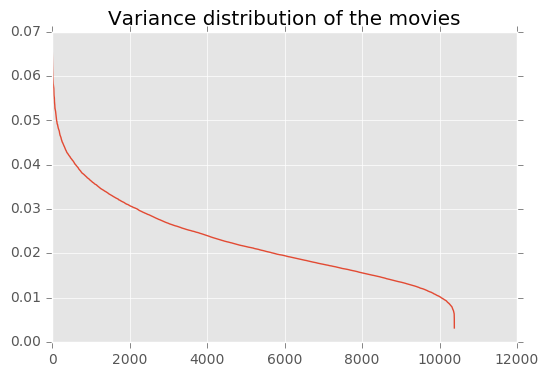

In [12]:
var = sorted(np.var(X, 0).tolist()[0], key=lambda x: -x)
plt.plot(var)
plt.title('Variance distribution of the movies')

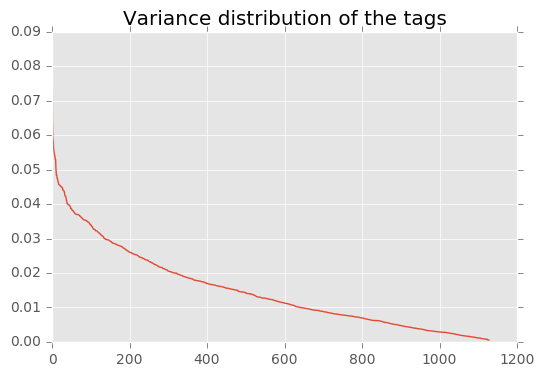

In [13]:
var2 = sorted(np.var(X, 1).T.tolist()[0], key=lambda x: -x)
plt.plot(var2)
plt.title('Variance distribution of the tags')

#### Question B

In [14]:
covarianceMatrix = (Xcentered * Xcentered.T) / X.shape[0]

In [15]:
covarianceMatrix.shape

(1128, 1128)

In [16]:
w, v = la.eigh(covarianceMatrix)

In [17]:
eigenvalues = -np.sort(-w)
print(eigenvalues)

[  9.58272817e+01   2.06639221e+01   1.03248271e+01 ...,   1.16946030e-03
   7.43780044e-04   5.15983007e-04]


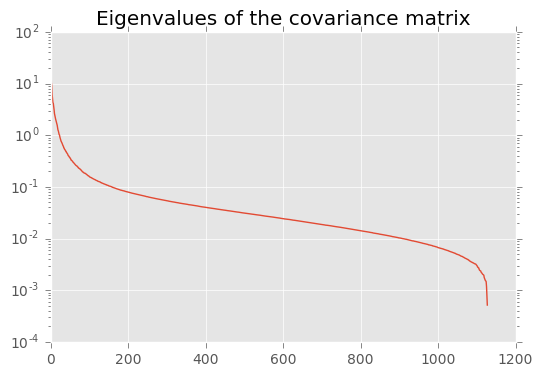

In [18]:
plt.semilogy(eigenvalues)
plt.title('Eigenvalues of the covariance matrix')

#### Question C

We can see that eigenvalues fall off very quickly. This means that a few directions can explain the data really well.

#### Conclusion

In [19]:
def directionsVariability(ww, ratio):
    currentRatio = 0.0
    i = 1
    while currentRatio < ratio:
        currentRatio = np.sum(ww[:i]) / np.sum(ww)
        i = i+1
    
    return i - 1

In [20]:
print('We need', directionsVariability(eigenvalues, 2/3), 'directions to explain 2/3 of the variability in the data')

We need 11 directions to explain 2/3 of the variability in the data


### Exercise 3.2

#### Setup

In [109]:
def getTopNEigenvectors(n, w, v):
    #Find the indices of the largest eigenvalues
    largestEigenvaluesIndex = w.argsort()[-n:][::-1]
    #Filter out from v the directions with lowest eigenvalues
    newV = v.T[largestEigenvaluesIndex]
    return -np.sort(-w)[:n], newV.T

ww, vv = getTopNEigenvectors(5, w, v)

In [259]:
#w and v need to be sorted in increasing order (numpy.eigh already does it)
def principalDirectionsDecomposition(n, w, v):
    newW = w[-n:]
    newV = v.T[-n:].T
    return newW, newV
    
newW, newV = principalDirectionsDecomposition(5, w, v)

In [260]:
def topTagsforConcepts(v, n):
    topTagsIndices = []
    for i in range(v.shape[1]):
        #I had to do it this way. taking [0] on the numpy array wasn't working
        column = np.array(np.squeeze(v[:,i]).tolist()[0])
        topTagsIndices.append((i, column.argsort()[-n:][::-1].tolist()))
    return topTagsIndices

def worstTagsforConcepts(v, n):
    worstTagsIndices = []
    for i in range(v.shape[1]):
        #I had to do it this way. taking [0] on the numpy array wasn't working
        column = np.array(np.squeeze(v[:,i]).tolist()[0])
        worstTagsIndices.append((i, column.argsort()[:n][::-1].tolist()))
    return worstTagsIndices

In [261]:
conceptsToTopTagsId = topTagsforConcepts(newV, 10)
print(conceptsToTopTagsId)

[(0, [1089, 1091, 534, 886, 889, 1090, 888, 885, 950, 121]), (1, [387, 899, 613, 496, 1034, 863, 259, 1002, 438, 323]), (2, [845, 556, 639, 609, 269, 800, 442, 1115, 844, 638]), (3, [142, 442, 556, 318, 633, 1036, 640, 193, 472, 790]), (4, [488, 14, 218, 118, 105, 116, 572, 784, 783, 346])]


In [262]:
conceptsToWorstTagsId = worstTagsforConcepts(newV, 10)

In [263]:
def getTagNames(ids):
    return tags.map(itemgetter('tagId', 'tag')).filter(lambda x: x[0] in ids).map(lambda x: x[1]).collect()

In [264]:
conceptsToTopTags = [(x[0], getTagNames([id+1 for id in x[1]])) for x in conceptsToTopTagsId]

In [265]:
print(conceptsToTopTags)

[(0, ['beautifully filmed', 'imagination', 'sci fi', 'sci-fi', 'science fiction', 'scifi', 'special effects', 'visual', 'visually appealing', 'visually stunning']), (1, ['courage', 'dramatic', 'feel-good', 'girlie movie', 'heartwarming', 'love story', 'romantic', 'sentimental', 'sweet', 'touching']), (2, ['criterion', 'golden palm', 'intimate', 'loneliness', 'meditative', 'melancholic', 'pornography', 'reflective', 'relationships', 'women']), (3, ['bleak', 'character study', 'downbeat', 'golden palm', 'grim', 'intimate', 'masterpiece', 'melancholy', 'poignant', 'tragedy']), (4, ['aardman', 'baseball', 'batman', 'beatles', 'claymation', 'emma watson', 'hannibal lecter', 'james bond', 'pirates', 'pixar'])]


Each tuple from previous list is a pair between one of direction that caught most of the data variability and a list of tags that have a high value in this direction. Looking at the tags we can deduce the following concepts for each direction.

Direction 0: Image quality

Direction 1: Positive emotions

Direction 2: Award movie

Direction 3: Deepness

Direction 4: Studios/Sequels

In [266]:
conceptsToWorstTags = [(x[0], getTagNames([id+1 for id in x[1]])) for x in conceptsToWorstTagsId]

In [267]:
print(conceptsToWorstTags)

[(0, ['corruption', 'crime', 'gangsters', 'manipulation', 'murder', 'police corruption', 'police investigation', 'suspense', 'thriller', 'violence']), (1, ['creepy', 'cult classic', 'cult film', 'dark', 'disturbing', 'horror', 'splatter', 'stylish', 'violence', 'weird']), (2, ['action', 'big budget', 'chase', 'exciting', 'fast paced', 'good action', 'plot', 'special effects', 'suspense', 'tense']), (3, ['action', 'bad plot', 'franchise', 'fun movie', 'original', 'predictable', 'silly', 'silly fun', "so bad it's funny", 'special effects']), (4, ['catastrophe', 'dialogue', 'good', 'good soundtrack', 'great', 'great ending', 'mentor', 'original', 'story', 'storytelling'])]


Each tuple from previous list is a pair between one of direction that caught most of the data variability and a list of tags that have a low value in this direction. Looking at the tags we can deduce the following concepts for each direction.

Direction 0: Polar genre

Direction 1: Negative emotions

Direction 2: Blockbusters

Direction 3: Light tone

Direction 4: Story focused

Looking at both directions for each axis, we can deduce the following concepts for each axis:

Axis 0:

Axis 1:

Axis 2:

Axis 3:

Axis 4:

#### Writing file to disk

In [231]:
def getTagName(id):
    return tags.map(itemgetter('tagId', 'tag')).filter(lambda x: x[0] == id).map(lambda x: x[1]).collect()

In [207]:
tagsToCoordinates = {}

for i in range(1, len(newV)):
    tagsToCoordinates.update({tag2name[i]: newV[i].tolist()[0]})

In [208]:
jsonarray = json.dumps(tagsToCoordinates, ensure_ascii=False)

with open('data.txt', 'w') as outfile:
    json.dump(jsonarray, outfile)

In [209]:
print(newV.shape)

(1128, 5)


### Exercise 3.3

In [210]:
import pickle

In [211]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
movies = sorted(movies, key=lambda x: x[0])
moviesIds = [movie[0] for movie in movies]

In [251]:
movies

[(260, 'Star Wars: Episode IV - A New Hope (1977)', 0.93),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (356, 'Forrest Gump (1994)', 0.72),
 (480, 'Jurassic Park (1993)', 0.93),
 (527, "Schindler's List (1993)", 0.96),
 (780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (805, 'Time to Kill, A (1996)', 0.67),
 (1199, 'Brazil (1985)', 0.98),
 (1240, 'Terminator, The (1984)', 1.0),
 (2324, 'Life Is Beautiful (La Vita è bella) (1997)', 0.8),
 (2329, 'American History X (1998)', 0.83),
 (2571, 'Matrix, The (1999)', 0.87),
 (2706, 'American Pie (1999)', 0.6),
 (2858, 'American Beauty (1999)', 0.88),
 (2959, 'Fight Club (1999)', 0.79),
 (3967, 'Billy Elliot (2000)', 0.85),
 (4465, 'Accused, The (1988)', 0.95),
 (4658, 'Santa Sangre (1989)', 0.85),
 (4700, 'Princess Diaries, The (2001)', 0.47),
 (5147, 'Wild Strawberries (Smultronstället) (1957)', 0.95),
 (5163, 'Stage Fright (Deliria) (1987)', 0.68),
 (5349, 'Spider-Man (2002)', 0.89),
 (5687, 'Take Care of My Cat (Goyangileul butagha

#### Question A

In [252]:
newMatrix = scoresGetter.map(itemgetter('movieId', 'relevance')).groupByKey().sortByKey().filter(lambda x: x[0] in moviesIds).map(lambda x: list(x[1])).collect()

In [253]:
newX = np.matrix(newMatrix)

print(newX.shape)

(37, 1128)


In [254]:
w2, v2 = principalDirectionsDecomposition(2, w, v)

In [255]:
projectedMatrix = (newX * v2).tolist()

In [256]:
print(projectedMatrix)

[[2.0893300546353504, -5.426914790378008], [4.7798756527706905, -7.005831293614132], [3.0891068583586843, -5.720596389488723], [0.5040908679323646, -4.657254604744452], [5.235154169255041, -5.9820308465410825], [-0.619546763288653, -3.638962682158663], [1.5902876955488527, -4.038491906764626], [3.9257951449722626, -5.198879006577363], [1.8429495418955506, -5.1268531813498015], [3.9822373589623643, -5.554794560022297], [5.291756690454118, -6.613882098485531], [2.6775037703474904, -6.027528562757453], [-0.11269701696355026, -3.800151139869716], [5.515006342204587, -6.8633884716835185], [4.979014694817191, -7.047067473896883], [2.9620590971683987, -4.574748022110336], [3.4184561597469916, -4.939231614220861], [3.5535225294013144, -4.411486955895904], [-0.8886969971584623, -2.5571835583797444], [5.271580829677336, -5.5090613838925275], [2.4464763192971968, -4.013630946662102], [-0.36545729277637856, -4.175436808630352], [1.7586746876617503, -2.108221973526682], [5.7563527389843845, -6.8083

In [257]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [258]:
# Categorial colors
from bokeh.palettes import Dark2_8
from matplotlib.colors import rgb2hex 

cmap = plt.get_cmap('viridis')
def val2rgb(val):
    return rgb2hex(cmap(val)[:3])

source = ColumnDataSource(
    data={
        "x": [x[0] for x in projectedMatrix],
        "y": [x[1] for x in projectedMatrix],
        "name": [x for x in movies],
        "color": [val2rgb(x[2]) for x in movies],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

#### Question 2

#### Question 3